## Análise do ano de 2024 e previsão para 2025 do sistema de transporte coletivo de BH

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

# Caminho da pasta
folder_path = # caminho dos arquivos baixados

# Lista para armazenar os DataFrames
dataframes = []

# Iterar sobre todos os arquivos na pasta
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep=';', encoding='latin1', usecols=['DATA', 'LINHA', 'VALIDACAO'])
        dataframes.append(df)

# Concatenar todos os DataFrames em um só
combined_df = pd.concat(dataframes, ignore_index=True)


C:\Users\Administrador\AppData\Local\Temp\ipykernel_10932\4139711411.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';', encoding='latin1', usecols=['DATA', 'LINHA', 'VALIDACAO'])
C:\Users\Administrador\AppData\Local\Temp\ipykernel_10932\4139711411.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';', encoding='latin1', usecols=['DATA', 'LINHA', 'VALIDACAO'])
C:\Users\Administrador\AppData\Local\Temp\ipykernel_10932\4139711411.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';', encoding='latin1', usecols=['DATA', 'LINHA', 'VALIDACAO'])
C:\Users\Administrador\AppData\Local\Temp\ipykernel_10932\4139711411.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  

In [20]:
combined_df = combined_df[combined_df['VALIDACAO'].notna() & (combined_df['VALIDACAO'] != '')]


In [48]:
# Cópia de segurança do DataFrame combinado
df = combined_df.copy()

In [33]:
df

,DATA,LINHA,VALIDACAO
0,2024-09-21,101,VALIDADA
1,2024-09-21,101,VALIDADA
2,2024-09-21,101,VALIDADA
3,2024-09-21,101,VALIDADA
4,2024-09-21,101,VALIDADA
...,...,...,...
7499767,NaN,SC02A,VALIDADA
7499768,NaN,SC03A,VALIDADA
7499769,NaN,SC04A,VALIDADA
7499770,NaN,SC04A,VALIDADA


In [34]:
df['LINHA'] = df['LINHA'].replace('8001', '8001A')


In [35]:
# Excluir as linhas 4040, 9033 e SE02
df = df[~df['LINHA'].isin(['4040', '9033', 'SE02'])]

In [36]:
# Transformar a variável alvo (VALIDACAO) em 0 e 1
df["VALIDACAO"] = df["VALIDACAO"].map({"VALIDADA": 1, "NAO VALIDADA": 0})

# Agrupar por DATA e LINHA, calculando a taxa de validação
df_time_series = df.groupby(["DATA", "LINHA"])["VALIDACAO"].mean().reset_index()

# Renomear a coluna da taxa de validação
df_time_series


C:\Users\Administrador\AppData\Local\Temp\ipykernel_10932\2984670247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["VALIDACAO"] = df["VALIDACAO"].map({"VALIDADA": 1, "NAO VALIDADA": 0})


,DATA,LINHA,VALIDACAO
0,01/01/2024,101,0.933333
1,01/01/2024,102,0.954545
2,01/01/2024,103,0.913043
3,01/01/2024,105,0.888889
4,01/01/2024,107,1.000000
...,...,...,...
101482,31/12/2024,SC01R,0.833333
101483,31/12/2024,SC02A,0.878788
101484,31/12/2024,SC03A,1.000000
101485,31/12/2024,SC04A,1.000000


In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def verificar_estacionariedade_por_linha(df):
    resultado_estacionariedade = {}

    for linha in df["LINHA"].unique():
        # Filtrar a série temporal da linha específica
        df_linha = df[df["LINHA"] == linha].sort_values("DATA")
        
        # Verificar se há variação na série
        if df_linha["VALIDACAO"].nunique() == 1:  
            resultado_estacionariedade[linha] = {
                "Estatística ADF": None,
                "p-valor": None,
                "Estacionária": "Constante"
            }
            continue  # Pula para a próxima linha
        
        # Aplicar o teste ADF
        resultado_adf = adfuller(df_linha["VALIDACAO"].dropna(), autolag="AIC")
        
        # Guardar os resultados
        resultado_estacionariedade[linha] = {
            "Estatística ADF": resultado_adf[0],
            "p-valor": resultado_adf[1],
            "Estacionária": resultado_adf[1] < 0.05  # True se a série for estacionária
        }

    # Converter para DataFrame
    df_resultado = pd.DataFrame.from_dict(resultado_estacionariedade, orient="index")
    return df_resultado

# Aplicar a função no DataFrame df_time_series
df_resultado_estacionariedade = verificar_estacionariedade_por_linha(df_time_series)




In [51]:
df_resultado_estacionariedade

,Estatística ADF,p-valor,Estacionária
101,-5.104032,1.375965e-05,True
102,-3.364786,1.221953e-02,True
103,-2.998292,3.505424e-02,True
105,-2.830393,5.406175e-02,False
107,-18.112106,2.535698e-30,True
...,...,...,...
2036,-1.935881,3.153745e-01,False
209,-2.460318,1.254302e-01,False
55,-2.334535,1.610715e-01,False
SC02B,NaN,NaN,Constante


In [52]:
# Lista das linhas que você quer analisar
linhas_para_analisar = ["209", "815", "9214", "5503A", "5503B", "85", "9211", "9105", "806", "9208"]

# Filtrar os resultados para essas linhas específicas
df_resultado_filtrado = df_resultado_estacionariedade[df_resultado_estacionariedade.index.isin(linhas_para_analisar)]



In [53]:
df_resultado_filtrado

,Estatística ADF,p-valor,Estacionária
5503A,-3.667299,4.597360e-03,True
806,-4.166064,7.516882e-04,True
815,-4.563620,1.506531e-04,True
9105,-4.299183,4.456611e-04,True
9208,-2.835349,5.339913e-02,False
9211,-4.083080,1.032812e-03,True
9214,-4.928169,3.072878e-05,True
5503B,-14.909985,1.463395e-27,True
85,-5.180475,9.635960e-06,True
209,-2.460318,1.254302e-01,False


In [54]:
# Recarregar as bibliotecas necessárias
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Lista das linhas que não são estacionárias
linhas_nao_estacionarias = ["9208", "209"]

# Criar um dicionário para armazenar os novos resultados após a diferenciação
resultado_estacionariedade_corrigido = {}

# Aplicar a diferenciação para cada linha não estacionária
for linha in linhas_nao_estacionarias:
    # Filtrar a série temporal da linha específica
    df_linha = df_time_series[df_time_series["LINHA"] == linha].sort_values("DATA")

    # Aplicar diferenciação de primeira ordem
    df_linha["TAXA_VALIDACAO_DIFF"] = df_linha["VALIDACAO"].diff()

    # Remover valores NaN gerados pela diferenciação
    df_linha = df_linha.dropna()

    # Aplicar novamente o teste ADF
    resultado_adf = adfuller(df_linha["TAXA_VALIDACAO_DIFF"], autolag="AIC")

    # Guardar os novos resultados
    resultado_estacionariedade_corrigido[linha] = {
        "Estatística ADF": resultado_adf[0],
        "p-valor": resultado_adf[1],
        "Estacionária": resultado_adf[1] < 0.05  # True se a série for estacionária
    }

# Converter os novos resultados para DataFrame
df_resultado_corrigido = pd.DataFrame.from_dict(resultado_estacionariedade_corrigido, orient="index")
df_resultado_corrigido


,Estatística ADF,p-valor,Estacionária
9208,-7.812933,6.991331e-12,True
209,-3.130755,2.435931e-02,True


In [55]:
# Atualizar os valores de Estatística ADF e p-valor para as linhas que foram diferenciadas
df_resultado_filtrado.loc["9208", "Estatística ADF"] = df_resultado_corrigido.loc["9208", "Estatística ADF"]
df_resultado_filtrado.loc["9208", "p-valor"] = df_resultado_corrigido.loc["9208", "p-valor"]
df_resultado_filtrado.loc["209", "Estatística ADF"] = df_resultado_corrigido.loc["209", "Estatística ADF"]
df_resultado_filtrado.loc["209", "p-valor"] = df_resultado_corrigido.loc["209", "p-valor"]

# Atualizar a coluna "Estacionária" para indicar que agora são estacionárias
df_resultado_filtrado.loc["9208", "Estacionária"] = True
df_resultado_filtrado.loc["209", "Estacionária"] = True




In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista para armazenar previsões
forecast_results = []

# Definir período de previsão (12 meses = 365 dias)
forecast_horizon = 365

# Loop para cada linha e gerar previsão separada
for linha in df_time_series["LINHA"].unique():
    # Filtrar os dados da linha específica
    df_linha = df_time_series[df_time_series["LINHA"] == linha][["DATA", "VALIDACAO"]]
    
    # Ordenar os dados por data
    df_linha = df_linha.sort_values("DATA")
    
    # Definir o índice como data para modelo de série temporal
    df_linha.set_index("DATA", inplace=True)
    
    # Ajustar o modelo SARIMA (ordem padrão, pode ser ajustada)
    model = SARIMAX(df_linha["VALIDACAO"], order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Fazer previsões para os próximos 12 meses
    forecast = model_fit.get_forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(start=df_linha.index[-1], periods=forecast_horizon + 1, freq="D")[1:]
    
    # Criar DataFrame com previsões
    df_forecast = pd.DataFrame({
        "DATA": forecast_index,
        "PREVISAO_TAXA_VALIDACAO": forecast.predicted_mean,
        "IC_INFERIOR": forecast.conf_int()["lower VALIDACAO"],
        "IC_SUPERIOR": forecast.conf_int()["upper VALIDACAO"],
        "LINHA": linha
    })
    
    # Adicionar à lista de resultados
    forecast_results.append(df_forecast)

# Concatenar todas as previsões
df_forecast_final = pd.concat(forecast_results, ignore_index=True)

# Plotar previsões para cada linha
plt.figure(figsize=(14, 7))


c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrador\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [57]:
df_forecast_final

,DATA,PREVISAO_TAXA_VALIDACAO,IC_INFERIOR,IC_SUPERIOR,LINHA
0,2025-01-01,0.871957,0.611993,1.131921,101
1,2025-01-02,0.903474,0.631246,1.175702,101
2,2025-01-03,0.946630,0.664666,1.228594,101
3,2025-01-04,0.918676,0.627377,1.209976,101
4,2025-01-05,0.909137,0.608795,1.209478,101
...,...,...,...,...,...
110225,2025-08-18,0.000000,-280775.457371,280775.457371,630
110226,2025-08-19,0.000000,-281608.805135,281608.805135,630
110227,2025-08-20,0.000000,-282439.694090,282439.694090,630
110228,2025-08-21,0.000000,-283268.145871,283268.145871,630


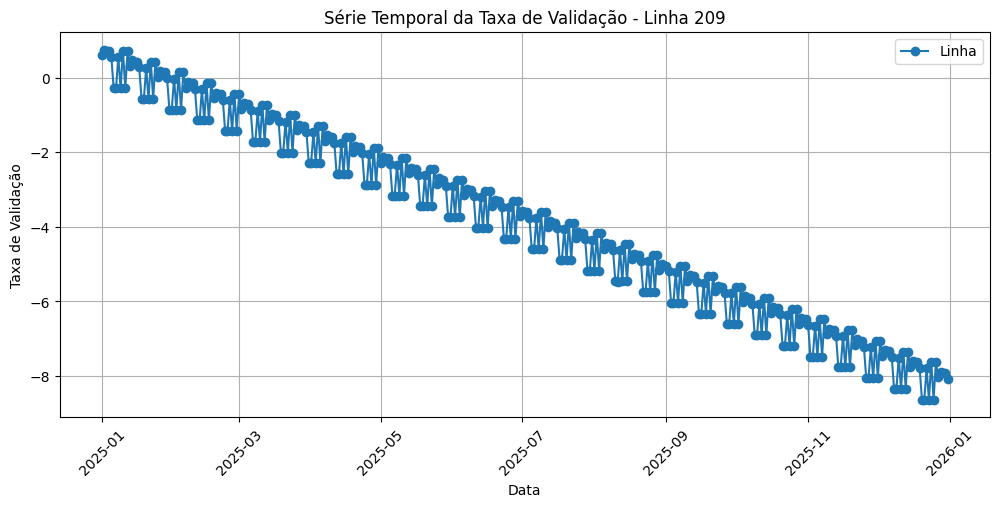

In [71]:

# Filtrar apenas a linha 101
df_linha_ = df_forecast_final[df_forecast_final["LINHA"] == "209"]

# Criar o gráfico
plt.figure(figsize=(12, 5))
plt.plot(df_linha_["DATA"], df_linha_["PREVISAO_TAXA_VALIDACAO"], marker='o', linestyle='-', label="Linha")

# Configurações do gráfico
plt.xlabel("Data")
plt.ylabel("Taxa de Validação")
plt.title("Série Temporal da Taxa de Validação - Linha 209")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Exibir o gráfico
plt.show()

In [42]:
# Transformar a variável alvo (VALIDACAO) em 0 e 1
df["VALIDACAO"] = df["VALIDACAO"].map({"VALIDADA": 1, "NAO VALIDADA": 0})

# Agrupar por DATA e LINHA, calculando a taxa de validação
df_time = df.groupby(["LINHA"])["VALIDACAO"].mean().reset_index()

# Renomear a coluna da taxa de validação
df_time.columns = ["LINHA", "TAXA_VALIDACAO"]

# Ordenar a TAXA_VALIDACAO da menor para a maior
df_time = df_time.sort_values(by='TAXA_VALIDACAO', ascending=True)

# Exibir o DataFrame resultante
df_time

,LINHA,TAXA_VALIDACAO
165,630,0.000000
214,8001,0.000000
301,SC02B,0.500000
27,209,0.691406
231,815,0.761414
...,...,...
194,710,0.997396
206,732,0.999265
97,4040,1.000000
262,9033,1.000000


In [45]:
# Excluir as linhas 9033, SE02, 6030, 800, SC02B, 4040
df_time = df_time[~df_time['LINHA'].isin(['9033', 'SE02', '630', '8001', 'SC02B', '4040'])]

# Exibir o DataFrame resultante
df_time

,LINHA,TAXA_VALIDACAO
27,209,0.691406
231,815,0.761414
278,9214,0.774300
139,5503A,0.782533
140,5503B,0.783200
...,...,...
157,621,0.995592
188,703,0.996547
193,709,0.996986
194,710,0.997396


In [46]:
# Selecionar as 10 primeiras linhas
top_10 = df_time.head(10)

# Selecionar as 10 últimas linhas
bottom_10 = df_time.tail(10)

# Concatenar as 10 primeiras e as 10 últimas linhas
top_bottom_10 = pd.concat([top_10, bottom_10])

# Exibir o DataFrame resultante
top_bottom_10

,LINHA,TAXA_VALIDACAO
27,209,0.691406
231,815,0.761414
278,9214,0.774300
139,5503A,0.782533
140,5503B,0.783200
253,85,0.784083
277,9211,0.799746
267,9105,0.802559
216,806,0.811962
274,9208,0.818973
